# Watson Exploratory Data Analysis

## Setup

### Sensitive Info

In [1]:
from sensitive_info import *

### Setup Anaconda Environment

In [2]:
%pip install ipykernel
%pip install --upgrade nbformat
%pip install pandas
%pip install sqlalchemy
%pip install psycopg2
%pip install matplotlib
%pip install seaborn
%pip install plotly

### Imports

In [3]:
# general imports
import string
import numpy as np

# SQL imports
import pandas as pd
from sqlalchemy import create_engine, URL
from sqlalchemy.sql import text

# EDA and plotting imports
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objects as go

### Import data from PostgreSQL

In [4]:
# create SQLAlchemy engine
url_object = URL.create(
    drivername="postgresql+psycopg2",
    username=USERNAME,
    password=PASSWORD,
    host=HOST,
    database=DATABASE,
    port=PORT
)
engine = create_engine(url=url_object)

# connect to database and extract data to dataframe
train_df = None
test_df = None
with engine.connect() as db_conn:
    sql_query = "SELECT * FROM watson.train"
    train_df = pd.read_sql_query(sql=text(sql_query), con=db_conn)

    sql_query = "SELECT * FROM watson.test"
    test_df = pd.read_sql_query(sql=text(sql_query), con=db_conn)

## EDA

### Basic Info

##### TRAIN

In [5]:
print(f'Train shape: {train_df.shape}')
train_df.head()

Train shape: (12120, 6)


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB


In [7]:
# Always check for null values in your data
train_df.isnull().any()

id            False
premise       False
hypothesis    False
lang_abv      False
language      False
label         False
dtype: bool

##### TEST

In [8]:
print(f'Test shape: {test_df.shape}')
test_df.head()

Test shape: (5195, 5)


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [9]:
# Always check for null values in your data
test_df.isnull().any()

id            False
premise       False
hypothesis    False
lang_abv      False
language      False
dtype: bool

##### OBSERVATIONS

Seems that only Train data contains labels, so we will be unable to check accuracy when predicting labels for the Test data.

None of the data has Null values, so no need to clean the data thus far.

The counts for each dataset are:
 - 12120    for Train
 - 5195     for Test

### Graphs

#### Pre-plotting work

In [10]:
# styling setup
sns.set_theme(style="whitegrid")

#change labels to their representative names
train_labels = train_df['label']
label_names = ['entailment', 'neutral', 'contradiction']
train_labels = list(map(lambda x: label_names[x], train_labels))

#### Analyzing Train data

In [11]:
Languages=pd.DataFrame()
Languages['Type']=train_df.language.value_counts().index
Languages['Count']=train_df.language.value_counts().values

py.init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Pie(labels=Languages['Type'], values=Languages['Count'],hole=0.2)])
fig.update_layout( title={
                    'text': "Percentage distribution of different Languages",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show()

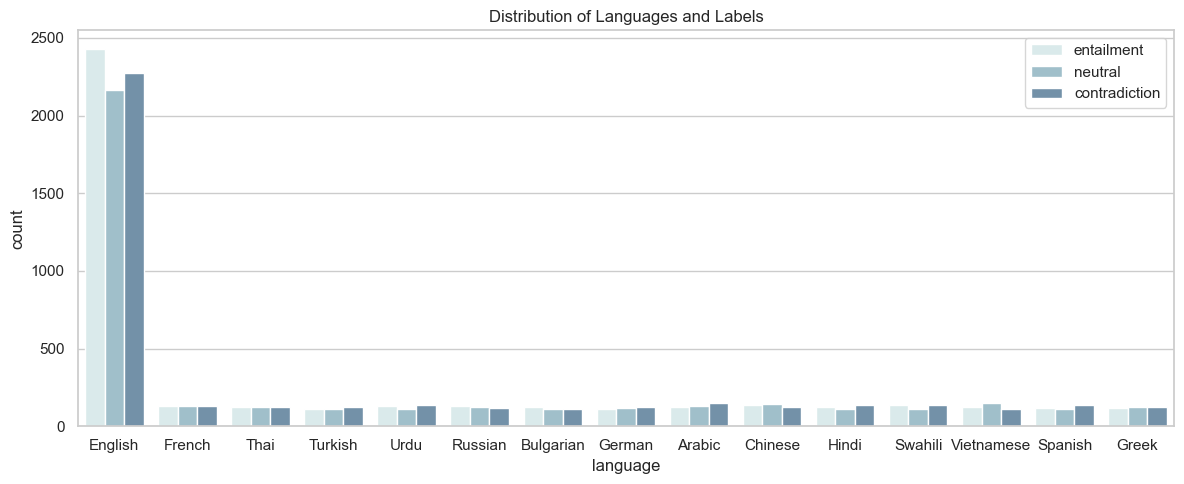

In [12]:
#explore the distribution of classes and languages
fig, ax = plt.subplots(figsize = (12, 5))

#for maximum aesthetics
palette = sns.cubehelix_palette(rot=-.2, light=0.9, dark=0)

graph1 = sns.countplot(x=train_df['language'], hue=train_labels, hue_order=label_names, palette=palette)

#set title
graph1.set_title('Distribution of Languages and Labels')


plt.tight_layout()
plt.show()

##### OBSERVATIONS

It seems to be relatively balanced between the 3 label types regardless of language.

English is overwhelming larger than any other language in the dataset. It seems that English makes up for around 50% of the entire dataset, while each other language is relatively evenly distributed among the remaining 50%, meaning around 3% per language.

#### Analysing differences between Train and Test

In [13]:
Languages_test=pd.DataFrame()
Languages_test['Type']=test_df.language.value_counts().index
Languages_test['Count']=test_df.language.value_counts().values
a = sum(Languages_test.Count)
Languages_test.Count = Languages_test.Count.div(a).mul(100).round(2)

In [14]:
a = sum(Languages.Count)
Languages.Count = Languages.Count.div(a).mul(100).round(2)

In [15]:
fig = go.Figure(data=[
    go.Bar(name='Train', x=Languages.Type, y=Languages.Count),
    go.Bar(name='Test', x=Languages_test.Type, y=Languages_test.Count)
])
# Change the bar mode
fig.update_layout(barmode='group',title={
                    'text': "Distribution across Train and Test",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show()

##### OBSERVATIONS

According to the graph, there doesn't seem to be any significant difference between train and test data for how the languages are distributed. Thus, we can safely assume that training and testing will not yield notable differences in accuracy due to a difference in language distribution.

#### Analyzing meta features between the Premise and Hypothesis

In [16]:
Meta_features = pd.DataFrame()

## Number of words in the text ##
Meta_features["premise_num_words"] = train_df["premise"].apply(lambda x: len(str(x).split()))
Meta_features["hypothesis_num_words"] = train_df["hypothesis"].apply(lambda x: len(str(x).split()))

## Number of characters in the text ##
Meta_features["premise_num_chars"] = train_df["premise"].apply(lambda x: len(str(x)))
Meta_features["hypothesis_num_chars"] = train_df["hypothesis"].apply(lambda x: len(str(x)))

## Number of punctuations in the text ##
Meta_features["premise_num_punctuations"] =train_df["premise"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
Meta_features["hypothesis_num_punctuations"] =train_df["hypothesis"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text ##
Meta_features["premise_mean_word_len"] = train_df["premise"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
Meta_features["hypothesis_mean_word_len"] = train_df["hypothesis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Meta_features['label'] = train_df['label']

In [17]:
fig = go.Figure()

categories = [0,1,2]
Name = ['Entailment','Contradiction','Neutral']
for category in categories:
    fig.add_trace(go.Violin(x=Meta_features['label'][Meta_features['label'] == category],
                            y=Meta_features['premise_num_words'][Meta_features['label'] == category],
                            name=Name[category],
                            box_visible=True,
                            meanline_visible=True))
    

fig.update_layout( title={
                    'text': "Number of Premise words per category",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show()

##### OBSERVATIONS

The three categories are fairly balanced, although one thing to note is that the Entailment Premises do not contain any outliers above 159 words, so we should be careful that the model does not learn this fact and rule out Entailment for higher word count Premises.

In [18]:
fig = go.Figure()
for category in categories:
    fig.add_trace(go.Violin(x=Meta_features['label'][Meta_features['label'] == category],
                            y=Meta_features['premise_num_punctuations'][Meta_features['label'] == category],
                            name=Name[category],
                            box_visible=True,
                            meanline_visible=True))
    

fig.update_layout( title={
                    'text': "Number of Punctuations in Premise per category",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show()

##### OBSERVATIONS

Similar to the previous graph, this one shows us that while although the punctuation stays relatively consistent, the outlier cases for Neutral Premises don't go as high as the other two, and thus we should watch out for the model learning this irrelavent behavior.

In [19]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Premise', x=Meta_features['premise_num_words'], xbins=dict(size=1)))
fig.add_trace(go.Histogram(name='Hypothesis', x=Meta_features['hypothesis_num_words'], xbins=dict(size=1)))

# Overlay both histograms
fig.update_layout(barmode='overlay',title={
                    'text': "Distribution of Words over Premise VS Hypothesis",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

##### OBSERVATIONS

Something initially seeming concerning, is that there are a large amount of 1 word Premises and Hypotheses. However, these are likely due to the way Chinese and possibly other languages are counting how many 'words' are in the entry as they do not use spaces to separate distinct words.

Putting this fact aside, we can still observe that the Hypothesis tends to be much shorter than the Premise in general.

In [20]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Premise', x=Meta_features['premise_num_punctuations'], xbins=dict(size=1)))
fig.add_trace(go.Histogram(name='Hypothesis', x=Meta_features['hypothesis_num_punctuations'], xbins=dict(size=1)))

# Overlay both histograms
fig.update_layout(barmode='overlay',title={
                    'text': "Distribution of Punctuations over Premise VS Hypothesis",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

##### OBSERVATIONS

Expectedly, the amount of punctuation in the Hypotheses tend to be less than the Premises, likely due to the fact that there are less words overall, and thus less punctuation for those words.

While the Premises do contain significantly more entries with 1 punctuation than the Hypotheses, this curve seems to resemble the previous graph, and thus does not raise concern.

In [21]:
fig = go.Figure()
fig.add_trace(go.Histogram(name='Premise', x=Meta_features['premise_num_chars'], xbins=dict(size=1)))
fig.add_trace(go.Histogram(name='Hypothesis', x=Meta_features['hypothesis_num_chars'], xbins=dict(size=1)))

# Overlay both histograms
fig.update_layout(barmode='overlay',title={
                    'text': "Distribution of Characters over Premise VS Hypothesis",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

##### OBSERVATIONS

This seems to be a much more insightful reading of the length of Premise vs Hypothesis, because of the afore mentioned issue about certain languages not using spaces.

As guessed earlier, we can now see for certain that Hypothesis contains many more entries within 100 characters, while Premise is more evenly spread up through 200+ characters.

Hypothesis looks more like a normal distribution curve, while Premise is more of a left-skewed or PERT distribution.

## Final Observation Summary

While the data overall is already structured well for model training, it will still be important to look out for a few things during training.
 - When looking at data with very long Premises or Hypotheses, the prediction may be influenced irrationally due to the lack of data we have for these longer entries.
 - The Premise tends to be longer than the Hypothesis, and it's character length curve cannot be normalized.